## Data

In [3]:
import pandas as pd
## pandas 1.1.1 necessary
import numpy as np
import string 
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import math
from gensim.models import Word2Vec
from plotly.graph_objects import Scatter3d
import matplotlib.pyplot as plt
import random

### Different Docs

In [144]:
merger = pd.read_pickle("../../raw_data/merger")
extract = merger[["index","content_y"]]

In [147]:
merger2 = pd.read_pickle("../../raw_data/merger2")
merger2["content_y"] = merger2["content"]
extract2 = merger2[["index","content_y"]]

In [265]:
merger3 = pd.read_pickle("../../raw_data/czech")
merger3 = merger3.reset_index()
merger3["content_y"] = merger3["content"]
extract3 = merger3[["index","content_y"]] 

In [288]:
merger4 = pd.read_pickle("../../raw_data/merger_spain")
merger4 = merger4.reset_index()
merger4["content_y"] = merger4["content"]
extract4 = merger4[["index","content_y"]] 

In [4]:
#Getting all the data
data = pd.read_pickle("../../delphes/data/update_age_sex")
data = data.reset_index()

In [336]:
extract2

,index,content_y
0,20738,"[False, False, [-0.0564866, 0.0520961, -0.0289..."
1,20739,"[False, [0.0680034, -0.0906367, -0.0319666, 0...."
2,20740,"[False, False, False, False, False, False, Fal..."
3,20741,"[[-0.0393396, 0.0268131, -0.142318, 0.0613933,..."
4,20742,"[[-0.0393396, 0.0268131, -0.142318, 0.0613933,..."
...,...,...
7795,130490,"[[0.0109718, -0.0593663, -0.0322032, 0.0416514..."
7796,130491,"[[0.0186351, -0.0140546, -0.0420493, -0.067852..."
7797,130492,"[[0.0489321, -0.0598671, -0.0264063, -0.014537..."
7798,130493,"[[-0.133483, 0.0550787, -0.0270976, 0.00313864..."


## Cleaning

In [250]:
def drop_none(df):
    count = 0
    dropables = []
    for i in df["content_y"]:
        if i == None:
            dropables.append(count)
            count+= 1
        else:
            count+=1
    result = df.drop(labels=dropables)
    result = result.reset_index()
    return result

In [251]:
#Creating a dict_tweets with Index and Averaged Array
def dict_creation(df):
    tweets = []
    dict_tweets = {}
    for i in df["level_0"]:
        prov_results = []
        try :
            if len(df["content_y"][i]) > 1: 
                for j in range (0,len(df["content_y"][i])): 
                    if df["content_y"][i] != False: 
                        prov_results.append(df["content_y"][i][j])
                    else:
                        pass
            dict_tweets[df["index"][i]] = (sum(prov_results)/len(df["content_y"][i]))
        except KeyError:
            break
    return dict_tweets

In [252]:
def drop_floats(dict_tweets):
    floats = []
    for i,j in dict_tweets.items(): 
        if type(j) != np.ndarray:
            floats.append(i)
    for i in floats: 
        del dict_tweets[i]
        
    return dict_tweets

In [253]:
dict_tweets = drop_floats(dict_creation(drop_none(extract)))

In [254]:
dict_tweets2 = drop_floats(dict_creation(drop_none(extract2)))

In [266]:
dict_tweets3 = drop_floats(dict_creation(drop_none(extract3)))

In [289]:
dict_tweets4 = drop_floats(dict_creation(drop_none(extract4)))

### Merging Dicts

In [291]:
merged_dict = {}
for i,j in dict_tweets.items():
    merged_dict[i] = j
for i,j in dict_tweets2.items():
    merged_dict[i] = j
for i,j in dict_tweets3.items():
    merged_dict[i] = j
for i,j in dict_tweets4.items():
    merged_dict[i] = j

## Creating DF

In [292]:
df = pd.DataFrame(merged_dict).transpose()
df = df.reset_index()
tsv_df = df.drop(['index'], axis=1)

### Merging

In [308]:
all_info = data.merge(df,on="index")

## Label Ecoding

### Country

In [309]:
for i in all_info.country.unique():
    print (i)

Spain
Denmark
Netherlands
Portugal
Ireland
Czechia


In [142]:
def countries(values):
    count = 0
    for i in all_countries.country_x.unique():
        if values == i:
            return count
        else:
            count += 1

In [138]:
all_info["countries"] = all_info["country"].apply(countries)

NameError: name 'all_info' is not defined

### European Group

In [139]:
def groups(values):
    if values == 'European Conservatives and Reformists Group':
        return 0
    elif values == 'Group of the European United Left - Nordic Green Left':
        return 1
    elif values == 'Group of the Progressive Alliance of Socialists and Democrats in the European Parliament':
        return 2
    elif values == "Group of the European People's Party (Christian Democrats)":
        return 3
    elif values == 'Group of the Greens/European Free Alliance':
        return 4
    elif values == 'Non-attached Members':
        return 5
    elif values == 'Renew Europe Group':
        return 6

In [315]:
all_info["european_group"] = all_info["group"].apply(groups)

### National Party

parties_list = ['Socialistisk Folkeparti',
       'Volkspartij voor Vrijheid en Democratie',
       'Christen Democratisch Appèl', 'Partij van de Arbeid',
       'ChristenUnie', 'GroenLinks', 'Forum voor Democratie',
       'Socialdemokratiet', 'Partij voor de Dieren', 'Democraten 66',
       'Venstre, Danmarks Liberale Parti', 'Det Radikale Venstre',
       'GO Realisme & Daadkracht', 'Staatkundig Gereformeerde Partij',
       'Enhedslisten', 'Det Konservative Folkeparti']

def parties(values):
    for i in parties_list:
        if values == i:
            return parties_list.index(i)

all_info["nat_party_code"] = all_info["nat_group"].apply(parties)

### Age

In [140]:
def age_func(values):
    if values <= 30:
        return 0
    if (values > 30) & (values <= 40):
        return 1
    if (values > 40) & (values <=50):
        return 2
    if (values > 50) & (values <= 60):
        return 3
    if values > 60:
        return 4

In [319]:
all_info["age_code"] = all_info["age"].apply(age_func)

In [323]:
all_info.to_pickle("six_countries")

## Exporting Document

### Words Matrix

In [305]:
tsv_df.to_csv('df.tsv',sep="\t", index=False, header=False)

### Labels

In [321]:
all_info[["countries","european_group","sex","age_code"]].to_csv("multi_variables.tsv",sep="\t", index=False, header=True)

In [238]:
!pwd

/Users/simonpastor/code/simonjpastor/delphes/notebooks/simonjpastor_notebooks


### Pierre's Model

In [353]:
test = pd.concat([extract, extract2, extract3, extract4])

## Distance Analysis

### Converting DF to Dictionary

In [128]:
all_countries = pd.read_hdf('../../raw_data/full_mean_df_hdf.h5', 'h5')

In [129]:
all_countries = all_countries.reset_index()

In [130]:
all_countries = all_countries.merge(data,on="index")

### Inital TSV

In [123]:
list_tsv = []
for i in (range(300)):
    list_tsv.append(i)

In [124]:
points = all_countries[list_tsv]

In [153]:
points.to_csv('df.tsv',sep="\t", index=False, header=False)

### Labels

In [132]:
all_countries=all_countries[["index","name_x","country_x","group_x","nat_group_x","age","sex"]]

In [143]:
all_countries["countries"] = all_countries["country_x"].apply(countries)

/Users/simonpastor/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [144]:
all_countries["group_code"] = all_countries["group_x"].apply(groups)

/Users/simonpastor/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [145]:
all_countries["age_code"] = all_countries["age"].apply(age_func)

/Users/simonpastor/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [152]:
points

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.012661,0.002554,-0.014151,0.012570,-0.028476,0.010816,0.028312,-0.031797,-0.006842,-0.000683,...,0.007531,-0.041275,0.029452,0.030989,0.010538,-0.049243,-0.025033,0.058314,0.019128,0.022892
1,-0.018363,0.009202,-0.018279,0.014551,-0.033121,0.002854,0.032446,-0.027741,-0.009103,-0.000443,...,0.010615,-0.039067,0.031028,0.025055,0.008500,-0.053187,-0.030836,0.053642,0.019144,0.015897
2,-0.019916,0.006455,-0.016012,0.012216,-0.035613,0.004092,0.029524,-0.028873,-0.009786,0.001495,...,0.005200,-0.037808,0.030887,0.027038,0.009016,-0.054631,-0.028361,0.054603,0.024452,0.018427
3,-0.010152,0.005874,-0.015779,0.023269,-0.035872,0.007126,0.025104,-0.031314,-0.009423,0.004061,...,0.016721,-0.040829,0.033006,0.023900,0.013247,-0.052095,-0.029642,0.054064,0.021562,0.014025
4,-0.017805,0.005459,-0.014992,0.011285,-0.030897,0.010802,0.030126,-0.028881,-0.006882,-0.002751,...,0.012571,-0.039137,0.037016,0.028174,0.013037,-0.056093,-0.035508,0.053920,0.019459,0.015463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134719,-0.032662,-0.020359,-0.000011,-0.035300,-0.029142,-0.011748,0.027723,-0.041714,-0.003765,0.001482,...,-0.006590,-0.010474,0.038501,0.017754,-0.031848,-0.114873,-0.063869,-0.001768,0.014983,0.010953
134720,-0.035984,-0.029438,0.006616,-0.037029,-0.033487,-0.008227,0.027761,-0.043713,-0.002894,-0.001037,...,-0.009227,-0.008789,0.036854,0.021920,-0.032733,-0.112913,-0.060042,-0.002471,0.018086,0.008367
134721,-0.028948,-0.023442,0.004493,-0.037035,-0.028807,-0.018014,0.025912,-0.044717,-0.004291,0.000520,...,-0.006545,-0.011271,0.042163,0.016308,-0.039746,-0.117086,-0.060991,-0.004830,0.018593,0.007534
134722,-0.034614,-0.024161,0.008099,-0.028324,-0.029430,-0.013675,0.031099,-0.049986,0.002875,-0.009035,...,-0.010266,-0.012133,0.036686,0.015777,-0.028820,-0.107009,-0.058627,0.000139,0.018164,0.005121


In [154]:
all_countries[["countries","group_code","sex","age_code"]].to_csv("multi_variables.tsv",sep="\t", index=False, header=True)

### Other Taff

In [7]:
list_extractor = []
list_extractor.append("index")
for i in (range(300)):
    list_extractor.append(i)

In [8]:
all_countries = all_countries[list_extractor]

In [9]:
dictionary = {}
for i in all_countries["index"]:
    temporary = []
    print(round(i/134724,1))
    for j in range(300):
        temporary.append(all_countries[j][i])
    dictionary[i] = np.array(temporary)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1


0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1


0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1


0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1


0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1


0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1


0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1


0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2


0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2


0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2


0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2


0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2


0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2


0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3


0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3


0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3


0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3


0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3


0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3


0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4


0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4


0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4


0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4


0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4


0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4


0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5


0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5


0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5


0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5


0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5


0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5


0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6


0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6


0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6


0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6


0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6


0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6


0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7


0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7


0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7


0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7


0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7


0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7


0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8


0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8


0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8


0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8


0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8


0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8


0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9


0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9


0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9


0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9


0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9


0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


KeyError: 134724

### Cosine Similarity

In [11]:
for i,j in dictionary.items():
    dictionary[i] = np.nan_to_num(j)

In [12]:
from sklearn.metrics.pairwise import cosine_similarity

distances = {}
def cosinux(x):
    for i in dictionary.keys():
        y = dictionary[i]
        result = cosine_similarity(x.reshape(-1, 1).transpose(), y.reshape(-1,1).transpose())
        distances[i] = result[0][0]
    return distances

In [13]:
def max_lists(x,top_x):
    distances = cosinux(x)
    maximum_list = []
    maximum_indexes = []
    for i, j in distances.items(): 
        if len(maximum_list) < top_x:
            maximum_list.append(j)
            maximum_indexes.append(i)
        else: 
            if j > min(maximum_list):
                maximum_list.append(j)
                del maximum_list[maximum_list.index(min(maximum_list))]
                maximum_indexes.append(i)
                del maximum_indexes[maximum_indexes.index(min(maximum_indexes))]
            else: 
                pass
    top100 = dict(zip(maximum_indexes,maximum_list))
    top100_df = pd.DataFrame([top100]).transpose().reset_index()
    return data.merge(top100_df,on="index")

### Stats

#### Country

In [14]:
def stats_country(x,top_x):
    df = max_lists(x,top_x)
    country_stats1=[]
    country_stats2=[]
    init = []
    sum = 0
    for i in df.groupby("country").count()[0].reset_index()["country"].values:
        country_stats1.append(i)
    for i in df.groupby("country").count().reset_index()[["country","index"]]["index"].values:
        init.append(i)
        sum += i
    for i in init:
        country_stats2.append((i/sum)*100)    
    country = dict(zip(country_stats1,country_stats2))
    country_viz = pd.DataFrame([country]).transpose().reset_index()
    return country_viz

#### European Group

In [15]:
def group_encoding(values):
    if values == "United Left":
        return (103/255, 0, 0)
    elif values == "Socialists & Democrats":
        return (201/255, 0, 0)
    elif values == 'Greens':
        return (6/255, 137/255, 0)
    elif values == 'Renew Europe':
        return (251/255, 247/255, 45/255)
    elif values == "EPP":
        return (120/255, 119/255, 235/255)
    elif values == 'European Conservatives and Reformists':
        return (4/255, 112/255, 180/255)
    elif values == 'Identity & Democracy':
        return (0, 0, 169/255)
    elif values == 'Non-Attached':
        return (120/255, 119/255, 127/255)

In [16]:
def name_order(df):
    dict_test = {}
    list1 = []
    list2 = []
    order = {}
    for i in df["index"]:
        list1.append(i)
    for j in df[0]:
        list2.append(j)
    unordered = dict(zip(list1,list2))
    try:
        order["United Left"] = unordered['Group of the European United Left - Nordic Green Left']
    except KeyError: 
        pass
    try:    
        order['Socialists & Democrats'] = unordered['Group of the Progressive Alliance of Socialists and Democrats in the European Parliament']
    except KeyError: 
        pass
    try: 
        order['Greens'] = unordered['Group of the Greens/European Free Alliance']
    except KeyError: 
        pass
    try:
        order['Renew Europe'] = unordered['Renew Europe Group']
    except:
        pass
    try:
        order["EPP"] = unordered["Group of the European People's Party (Christian Democrats)"]
    except KeyError: 
        pass
    try:
        order["European Conservatives and Reformists"] = unordered['European Conservatives and Reformists Group']
    except KeyError: 
        pass
    try:
        order["Identity & Democracy"] = unordered["Identity and Democracy Group"]
    except KeyError: 
        pass
    try: 
        order['Non-Attached'] = unordered['Non-attached Members']
    except KeyError: 
        pass
    df = pd.DataFrame([order]).transpose().reset_index()
    return df

In [17]:
def stats_group(x,top_x):
    df = max_lists(x,top_x)
    country_stats1=[]
    country_stats2=[]
    init=[]
    sum = 0
    for i in df.groupby("group").count()[0].reset_index()["group"].values:
        country_stats1.append(i)
    for i in df.groupby("group").count().reset_index()[["group","index"]]["index"].values:
        init.append(i)
        sum += i
    for i in init:
        country_stats2.append((i/sum)*100)
    group = dict(zip(country_stats1,country_stats2))
    group_viz = pd.DataFrame([group]).transpose().reset_index()
    group_viz = name_order(group_viz)
    group_viz["group_colors"] = group_viz["index"].apply(group_encoding)
    return group_viz

#### Sex

In [88]:
def stats_sex(x,top_x):
    df = max_lists(x,top_x)
    sex_stats1=[]
    sex_stats2=[]
    init=[]
    sum = 0
    for i in df.groupby("sex").count()[0].reset_index()["sex"].values:
        sex_stats1.append(i)
    for i in df.groupby("sex").count().reset_index()[["sex","index"]]["index"].values:
        init.append(i)
        sum += i
    for i in init:
        sex_stats2.append((i/sum)*100)
    group = dict(zip(sex_stats1,sex_stats2))
    group["Men"] = group[0]
    group["Women"] = group[1]
    del group[0]
    del group[1]
    group_viz = pd.DataFrame([group]).transpose().reset_index()
    return group_viz

#### Age

In [19]:
def stats_age(x,top_x):
    df = max_lists(x,top_x)
    age_stats1=[]
    age_stats2=[]
    init=[]
    sum = 0
    for i in df.groupby("age").count()[0].reset_index()["age"].values:
        age_stats1.append(i)
    for i in df.groupby("age").count().reset_index()[["age","index"]]["index"].values:
        init.append(i)
        sum += i
    for i in init:
        age_stats2.append((i/sum)*100)
    group = dict(zip(age_stats1,age_stats2))
    group_viz = pd.DataFrame([group]).transpose().reset_index()
    return group_viz

### Plot the Output 

In [20]:
def color_generator(colors):
    color_list = {}
    color_output = []
    count = 0
    for i in range(0,colors):
        color_list[count] = ((random.random(), random.random(), random.random()))
        count += 1
    for i in color_list.values():
        color_output.append(i)
    return color_output

In [21]:
def group_color(x):
    color_order=[]
    for i in x["group_colors"]:
        color_order.append(i)
    return color_order

In [74]:
def stats(top_x):
    x = array_reductor(vect_tweet())
    minutes = 0
    mins = top_x/10
    while mins > 0:
        mins = mins - 60
        minutes += 1 
    print(f'Estimated Wait Time : {minutes} mins')
    fig,axs = plt.subplots(nrows=2,ncols=2,figsize=(30,20))
    #1st one
    variable = stats_country(x,top_x)
    colors = variable["index"].count()
    axs[0,0].bar(variable["index"],variable[0],color=color_generator(colors))
    axs[0,0].set_title("Proportion of MEP's Nationalities",fontsize=20)
    #2nd one
    variable = stats_group(x,top_x)
    colors = group_color(variable)
    axs[0,1].bar(variable["index"],variable[0],color=colors)
    axs[0,1].set_title("Proportion by European Political Group",fontsize=20)
    #3rd one
    variable = stats_sex(x,top_x)
    colors = variable["index"].count()
    axs[1,0].bar(variable["index"],variable[0],color=color_generator(colors))
    axs[1,0].set_title("Proportion of Men and Women",fontsize=20)
    #4th one
    variable = stats_age(x,top_x)
    colors = variable["index"].count()
    axs[1,1].bar(variable["index"],variable[0])
    axs[1,1].set_title("Age Spread",fontsize=20)
    plt.suptitle("Statistics on the Top100 Most Similar Tweets",fontsize=40)
    plt.show()

## Input

In [29]:
import pandas as pd
import numpy as np
import io
from googletrans import Translator, LANGUAGES
from time import sleep
import string

In [31]:
languages = ["french","english"]

In [33]:
def load_vec(emb_path, nmax=50000):
    vectors = []
    word2id = {}
    with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        next(f)
        for i, line in enumerate(f):
            word, vect = line.rstrip().split(' ', 1)
            vect = np.fromstring(vect, sep=' ')
            assert word not in word2id, 'word found twice'
            vectors.append(vect)
            word2id[word] = len(word2id)
            if len(word2id) == nmax:
                break
    id2word = {v: k for k, v in word2id.items()}
    embeddings = np.vstack(vectors)
    return embeddings, id2word, word2id

In [34]:
nmax = 100000  # maximum number of word embeddings to load
emb_dict = {}
for lang in languages:
    path = f"../../raw_data/vectors_{lang}.txt" #Select here
    embeddings, id2word, word2id = load_vec(path, nmax)
    emb_dict[lang] = [embeddings, id2word, word2id]

In [35]:
def multilang_word_vector(word, emb_dict, lang=None):
    translator = Translator()
    if lang == None: lang = LANGUAGES[translator.detect(word).lang]
    lang_val = LANGUAGES.values()
    if lang in lang_val and lang in emb_dict.keys():
        if word in emb_dict.get(lang)[2].keys():
            return emb_dict[lang][0][emb_dict[lang][2][word]]
    return False

In [77]:
def vect_tweet():
    tweet = input("Please write about anything: ")
    translator = Translator()
    if translator.detect(tweet).lang in LANGUAGES.keys():
        lang = LANGUAGES[translator.detect(tweet).lang]
        words = tweet.split(" ")
        res = []
        for i in words:
            res.append(multilang_word_vector(i, emb_dict, lang))
        return res
    return None

In [68]:
X = vect_tweet("J'aime la France, elle est si belle, la République, notre République, Marianne, Front National, Paris, Marseille, Strasbourg, Baguette, Tour Eiffel, Fédération française ")

In [64]:
def array_reductor(array):
    #Cleans the Array and returns it into a single dimension
    length = 0
    words_list = []
    for j in array:
        if type(j) == np.ndarray:  
            words_list.append(j)
            length += 1
    result = (sum(words_list)/length)
    return result

Please write about anything: écologie, france environnement nature poule animaux pollution plastique air carbone consommation
Estimated Wait Time : 1 mins


KeyError: 0

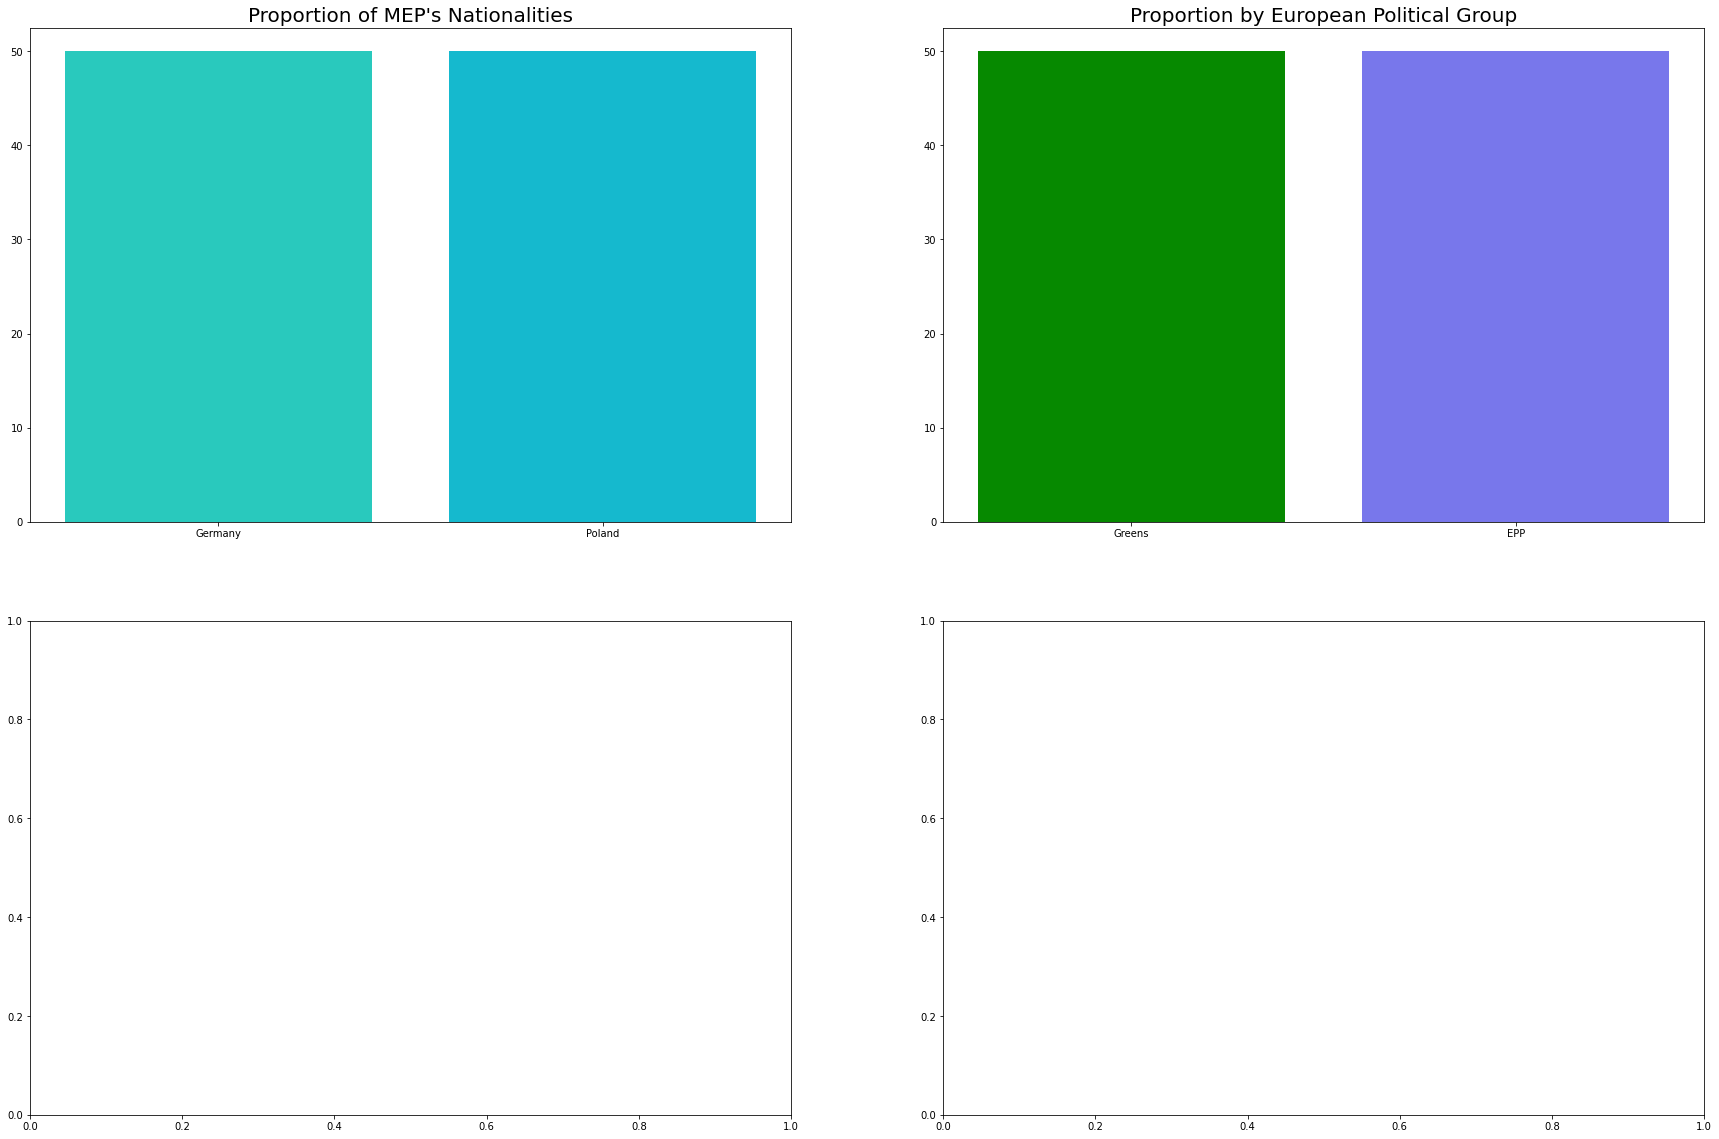

In [89]:
stats(2)

## Twitter Entry

In [78]:
from tweepy import OAuthHandler
from tweepy import API
from tweepy import Cursor
from datetime import datetime, date, time, timedelta
from collections import Counter
import sys

In [80]:
consumer_key="MlhCiJ0f4TGtfKqwZHDMWNPEW"
consumer_secret="1vDWbwCDH4qXWJKXhmHH4JUwIVaLwQqer8VYsvJp5stvUufbGS"
access_token_key="871991040256999424-zzPkWFFCxjuD1SG1hXU4sP8G1dAutAM"
access_token_secret="D6AhmrT89yCGtFcN31CPJ7YsXSXXy61HbuWWOZI5pkMOX"

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token_key, access_token_secret)
api = API(auth, wait_on_rate_limit=True)

In [90]:
def get_tweets():
    content_list = []
    for tweet in Cursor(api.user_timeline,id="the_simonpastor",tweet_mode='extended').items(10):
        if "retweeted_status" in dir(tweet):
            tweet=tweet.retweeted_status.full_text
            content_list.append(tweet)
        else:
            tweet=tweet.full_text
            content_list.append(tweet)
    return content_list

In [91]:
get_tweets()

['@TheEconomist https://t.co/JrifERQIi0',
 'There’s nothing like Le Tour de France 😍\n#LeTour2020',
 'Huge Twitter project coming up in two weeks !!! Stay tuned 🙂You’ll love it ! ❤️',
 'Coolest civic/ gov techs you know?',
 "3 months ago, I wrote about how Covid could affect social interactions, which I argued could result in a community come-back, increased loneliness and a questioning of one's social circles.\n\nWhat do you think? \n\nOr is it still too early to tell...\n\nhttps://t.co/KRh33TIzuc",
 'https://t.co/mrJTKTyVkg is my new favorite cooking website 😍 It almost encourages me to start cooking 😂 https://t.co/LHqqVNQmEi',
 "A wordcloud of Obama's speech at the 2020 #DNC 🇺🇸 https://t.co/eJaQ621J1Z",
 'Saw this on Linkedin today, have to admit I was touched https://t.co/e3WcwzK3UC',
 'Does anyone work for or knows about interesting political data companies?',
 'Bravo à l’@OL pour son parcours héroïque et au @FCBayern pour sa qualification en finale de la Ligue des Champions. Dima